# Advanced Deep Learning Project
## Adapting BLIP to Radiology Visual Question Answering
## Members: Francesco Palma, Sara Zappia

# Setup

## Environment Configuration


In [1]:
# Setup Requirements for Official BLIP Repo

!pip install --upgrade pip setuptools wheel
!pip uninstall -y tokenizers transformers fairscale timm
!pip install tokenizers==0.21.0
!pip install transformers==4.26.1
!pip install fairscale==0.4.4
!pip install timm==0.4.12

!git clone https://github.com/salesforce/BLIP.git
%cd BLIP
!pip install -e .

Found existing installation: tokenizers 0.13.3
Uninstalling tokenizers-0.13.3:
  Successfully uninstalled tokenizers-0.13.3
Found existing installation: transformers 4.26.1
Uninstalling transformers-4.26.1:
  Successfully uninstalled transformers-4.26.1
Found existing installation: fairscale 0.4.4
Uninstalling fairscale-0.4.4:
  Successfully uninstalled fairscale-0.4.4
Found existing installation: timm 0.4.12
Uninstalling timm-0.4.12:
  Successfully uninstalled timm-0.4.12
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Using cached transformers-4.26.1-py3-none-any.whl.metadata (100 kB)
  Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.26.1-py3-none-any.whl (6.3 MB)
Using cached tokenizers-0.13.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014

In [2]:
# Make Repo Importable

import sys
sys.path.append("/kaggle/working/BLIP")

In [3]:
# Necessary Imports

import os
import re
import random
import torch
import math
import time
from pprint import pprint
import numpy as np
from torchvision import transforms
import pandas as pd
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from models.blip import blip_decoder
from models.blip_vqa import blip_vqa
from models.blip_pretrain import blip_pretrain
from models.blip import init_tokenizer
from collections import Counter, defaultdict
from difflib import SequenceMatcher
from tqdm.notebook import tqdm
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader, IterableDataset
from transformers import BlipProcessor, BlipForQuestionAnswering, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel, Image, load_dataset, concatenate_datasets
import json

2025-09-28 20:15:51.266358: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759090551.292002     320 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759090551.299674     320 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# VQA-RAD Dataset Processing

This section loads and preprocesses the VQA-RAD dataset for medical visual question answering. We create proper train/validation/test splits and analyze the dataset composition including question and answer types.


In [4]:
# Reproducibility

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# Settings

ft_config = {
    'model_dir': 'baseline',
    'model_path': 'best_model.pth',
    'epochs': 15,
    'batch_size': 8,
    'init_lr': 1e-5,
    'weight_decay': 0.01,
    'max_grad_norm': 1.0,
    'patience': 4,
    'freeze_vision': True,
    'eta_min' : 1e-6
}

dapt_config = {
    'vit_grad_ckpt': True,
    'queue_size' : 256,
    'image_size' : 224,
    'alpha': 0,
    'output_dir': 'dapt_roco_psd',
    'num_epochs': 2,           # Optimal for medical adaptation
    'batch_size': 16,
    'grad_accum_steps': 4,
    'shuffle_buffer': 256,     # Larger buffer for better shuffling
    'num_workers': 2,
    'tau': 0.995,              # Slightly lower for faster teacher adaptation
    'lr': 4e-7,                # Tuned for medical domain
    'warmup_lr': 5e-9,
    'min_lr': 1e-9,
    'weight_decay': 0.02,      # Slightly higher for regularization
    'max_grad_norm': 1.0,
    'save_every': 1,           # Save every epoch
}

In [6]:
# Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Datasets

## VQA-RAD

In [7]:
# Download and Process Original VQA-RAD

data_dir = "/kaggle/input/vqa-rad-osf"
json_path = os.path.join(data_dir, "VQA_RAD Dataset Public.json")

df = pd.read_json(json_path)

image_folder = os.path.join(data_dir, "VQA_RAD Image Folder")
df["image"] = df["image_name"].apply(lambda x: os.path.join(image_folder, x))

freeform_df = df[df["phrase_type"] == "freeform"]

np.random.seed(42)
sampled_freeform = freeform_df.sample(n=300, random_state=42)

linked_ids = sampled_freeform["qid_linked_id"].unique()
paraphrased_df = df[(df["phrase_type"] == "para") & (df["qid_linked_id"].isin(linked_ids))]

test_df = pd.concat([sampled_freeform, paraphrased_df], ignore_index=True)

train_df = df.drop(test_df.index).reset_index(drop=True)

selected_cols = [
    "image", "qid", "qid_linked_id", "phrase_type", "image_organ",
    "question", "question_type", "answer", "answer_type"
]
train_df = train_df[selected_cols].copy()
test_df = test_df[selected_cols].copy()

train_df["question_type"] = train_df["question_type"].str.strip()
test_df["question_type"] = test_df["question_type"].str.strip()
train_df["answer_type"] = train_df["answer_type"].str.strip()
test_df["answer_type"] = test_df["answer_type"].str.strip()

for col in ["qid", "qid_linked_id", "question", "answer"]:
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].astype(str)

answer_type_classes = sorted(train_df["answer_type"].unique().tolist())

features = Features({
    "image": Image(),
    "qid": Value("string"),
    "qid_linked_id": Value("string"),
    "phrase_type": Value("string"),
    "image_organ": Value("string"),
    "question": Value("string"),
    "question_type": Value("string"),   # raw string, keep multi-label info
    "answer": Value("string"),
    "answer_type": Value("string"),    # keep as string
})

train_ds = Dataset.from_pandas(train_df, features=features, preserve_index=False)
test_ds = Dataset.from_pandas(test_df, features=features, preserve_index=False)

dataset = DatasetDict({"train": train_ds, "test": test_ds})

print("\nDataset summary:")
pprint(dataset)

print("\nTrain features:")
pprint(dataset["train"].features)

print("\nFirst train example:")
pprint(dataset["train"][0])


Dataset summary:
DatasetDict({
    train: Dataset({
        features: ['image', 'qid', 'qid_linked_id', 'phrase_type', 'image_organ', 'question', 'question_type', 'answer', 'answer_type'],
        num_rows: 1786
    })
    test: Dataset({
        features: ['image', 'qid', 'qid_linked_id', 'phrase_type', 'image_organ', 'question', 'question_type', 'answer', 'answer_type'],
        num_rows: 462
    })
})

Train features:
{'answer': Value(dtype='string', id=None),
 'answer_type': Value(dtype='string', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'image_organ': Value(dtype='string', id=None),
 'phrase_type': Value(dtype='string', id=None),
 'qid': Value(dtype='string', id=None),
 'qid_linked_id': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'question_type': Value(dtype='string', id=None)}

First train example:
{'answer': 'No',
 'answer_type': 'CLOSED',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=400x501 at 0x7B7B28703

In [8]:
# Create Validation Set from Train Set

train_df["stratify_key"] = train_df["answer_type"] + "_" + train_df["phrase_type"]

train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df["stratify_key"]
)

train_df = train_df.drop(columns=["stratify_key"])
val_df = val_df.drop(columns=["stratify_key"])

val_ds = Dataset.from_pandas(val_df, features=features, preserve_index=False)

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df, features=features, preserve_index=False),
    "validation": val_ds,
    "test": test_ds
})

print("\nDataset summary with stratified validation split:")
pprint(dataset)
print("\nNumber of rows per split:")
print({k: len(dataset[k]) for k in dataset})


Dataset summary with stratified validation split:
DatasetDict({
    train: Dataset({
        features: ['image', 'qid', 'qid_linked_id', 'phrase_type', 'image_organ', 'question', 'question_type', 'answer', 'answer_type'],
        num_rows: 1607
    })
    validation: Dataset({
        features: ['image', 'qid', 'qid_linked_id', 'phrase_type', 'image_organ', 'question', 'question_type', 'answer', 'answer_type'],
        num_rows: 179
    })
    test: Dataset({
        features: ['image', 'qid', 'qid_linked_id', 'phrase_type', 'image_organ', 'question', 'question_type', 'answer', 'answer_type'],
        num_rows: 462
    })
})

Number of rows per split:
{'train': 1607, 'validation': 179, 'test': 462}


## Dataset Analysis and Visualization

We analyze the dataset composition including split sizes, answer type distributions, question and answer length statistics, and sample visualizations to better understand the characteristics of the medical VQA task.


=== Showing 6 Examples from TRAIN split ===



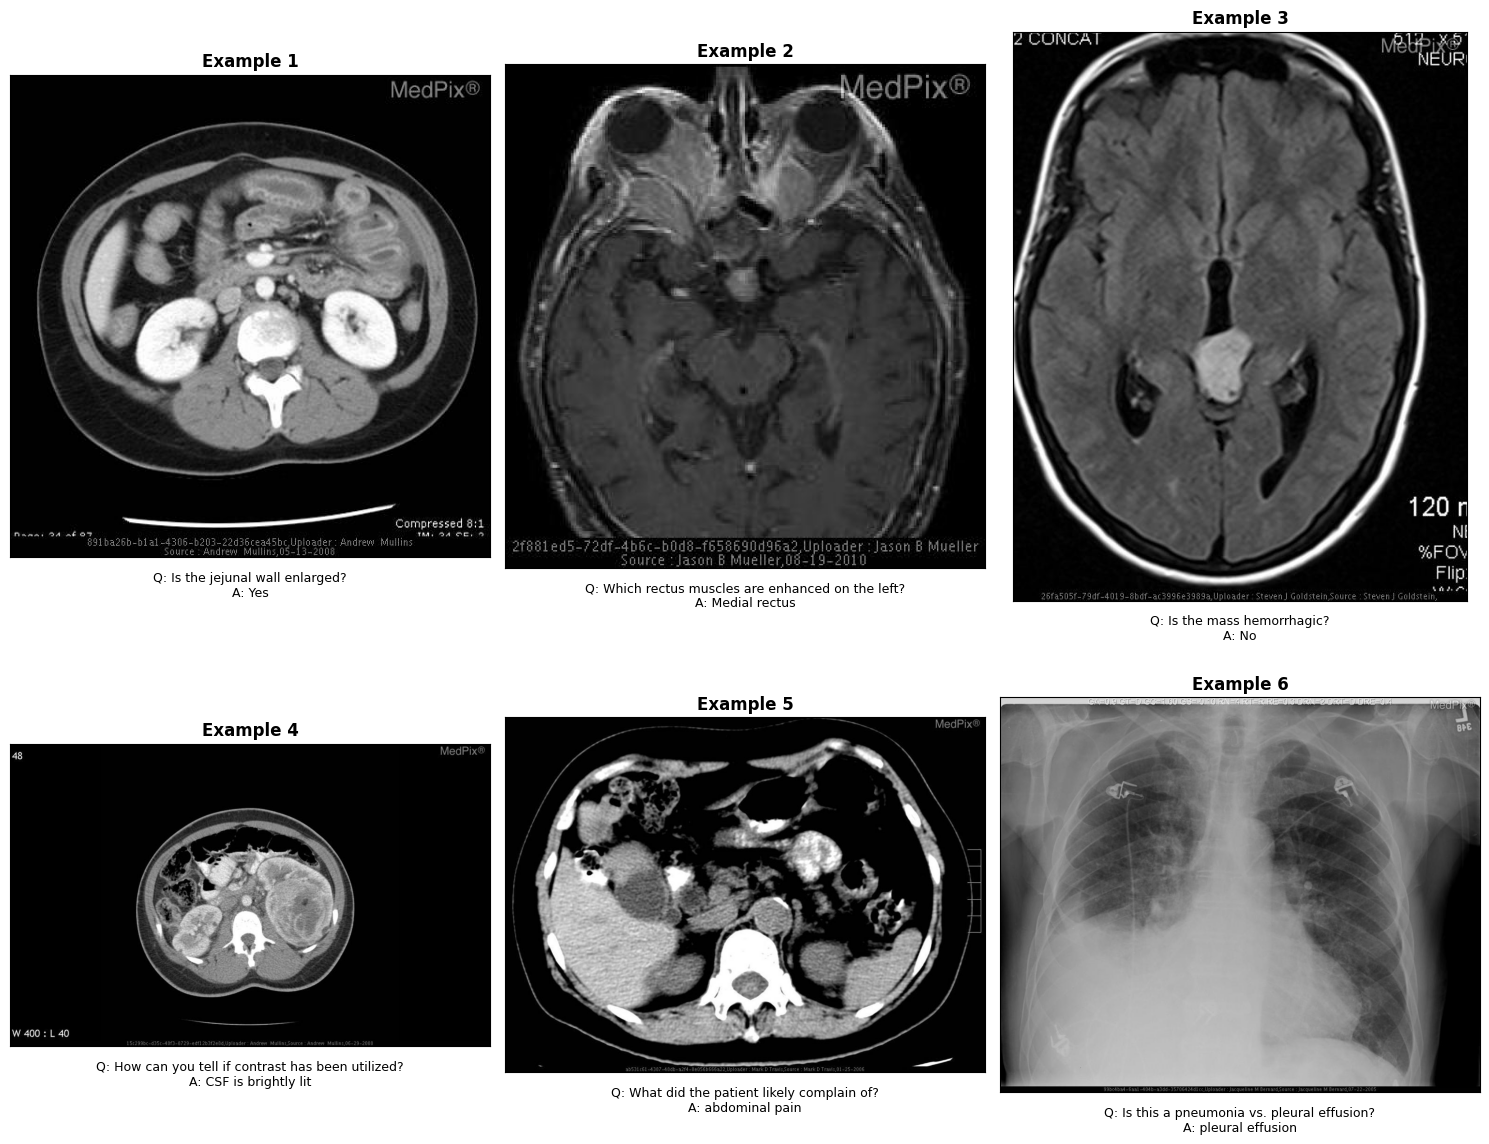

In [9]:
def show_dataset_examples(dataset, split_name="train", num_examples=6, randomize=True, cols=3):
    """
    Show sample examples (Image + Question + Answer) from the dataset
    with dynamic grid layout. Q&A are shown below images (always visible).
    """
    split_data = dataset[split_name]
    total = len(split_data)
    actual_examples = min(num_examples, total)

    # Pick random or sequential samples
    indices = random.sample(range(total), actual_examples) if randomize else range(actual_examples)
    
    print(f"\n=== Showing {actual_examples} Examples from {split_name.upper()} split ===\n")
    
    # Dynamic grid
    rows = math.ceil(actual_examples / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 6*rows))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        ex = split_data[idx]

        # Show image
        axes[i].imshow(ex['image'])
        axes[i].set_xticks([])  # hide x ticks
        axes[i].set_yticks([])  # hide y ticks
        axes[i].set_title(f"Example {i+1}", fontsize=12, fontweight="bold")

        # Put Q&A below image
        qa_text = f"Q: {ex['question']}\nA: {ex['answer']}"
        axes[i].set_xlabel(qa_text, fontsize=9, labelpad=10, ha="center")

    # Hide unused subplots if any
    for j in range(actual_examples, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

show_dataset_examples(dataset, split_name="train", num_examples=6, randomize=True)

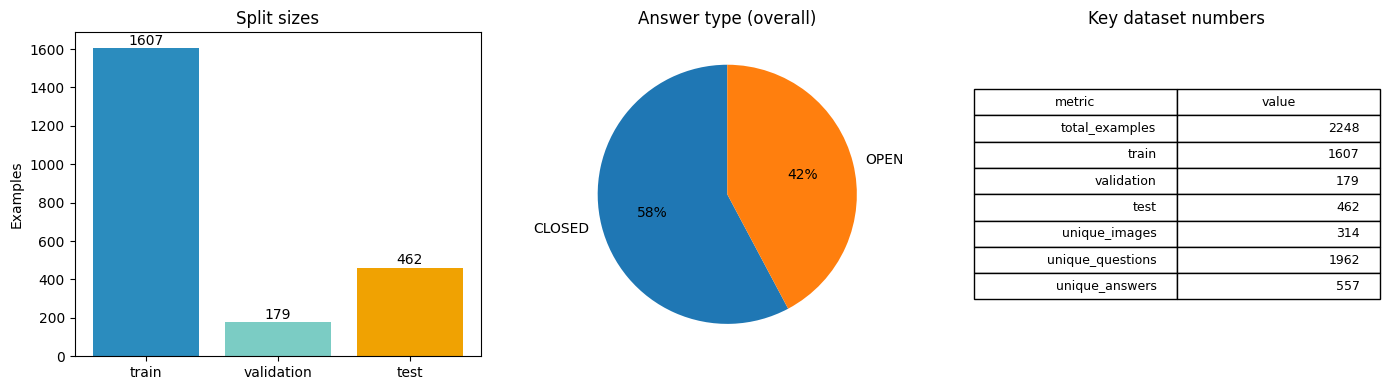

In [10]:
# Overview: split sizes (bar), answer_type composition (pie), and key numeric summary (table)

splits = {"train": len(train_df), "validation": len(val_df), "test": len(test_df)}

if "answer_type" in df.columns:
    ans_counts = (
        df["answer_type"]
        .fillna("UNK")        # fill missing
        .astype(str)
        .str.strip()          # remove leading/trailing spaces
        .str.upper()          # unify case
        .value_counts()
    )
    ans_counts = ans_counts[ans_counts > 0]  # remove any zero-count labels
else:
    ans_counts = pd.Series(dtype=int)

stats = {
    "total_examples": len(df),
    "train": len(train_df),
    "validation": len(val_df),
    "test": len(test_df),
    "unique_images": int(df.get("image_name", df.get("image", pd.Series())).nunique()),
    "unique_questions": int(df["question"].nunique()) if "question" in df.columns else None,
    "unique_answers": int(df["answer"].nunique()) if "answer" in df.columns else None
}
stats_df = pd.DataFrame(list(stats.items()), columns=["metric","value"])

fig, axes = plt.subplots(1,3, figsize=(14,4))

axes[0].bar(splits.keys(), splits.values(), color=["#2b8cbe","#7bccc4","#f0a202"])
axes[0].set_title("Split sizes")
axes[0].set_ylabel("Examples")
for i,(k,v) in enumerate(splits.items()):
    axes[0].text(i, v+max(splits.values())*0.01, str(v), ha='center')

if not ans_counts.empty:
    axes[1].pie(ans_counts.values, labels=ans_counts.index, autopct="%1.0f%%", startangle=90)
    axes[1].set_title("Answer type (overall)")
else:
    axes[1].axis('off')
    axes[1].text(0.5,0.5,"answer_type not present", ha='center')

axes[2].axis('off')
tbl = axes[2].table(cellText=stats_df.values, colLabels=stats_df.columns, loc='center')
tbl.auto_set_font_size(False); tbl.set_fontsize(9); tbl.scale(1,1.5)
axes[2].set_title("Key dataset numbers")

plt.tight_layout()
plt.show()

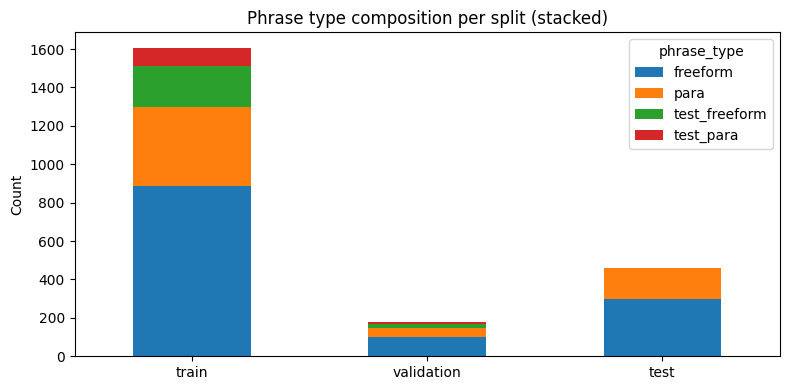

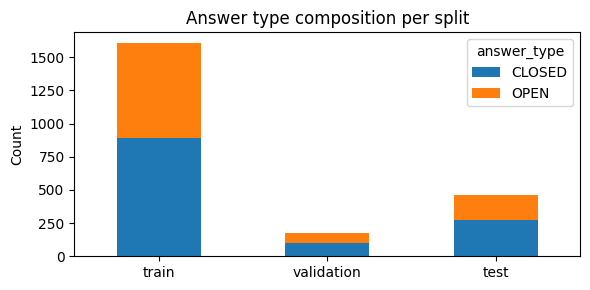

In [11]:
# Phrase type & answer type per split: stacked bars + counts table

def counts_for(col):
    return pd.DataFrame({
        "train": train_df[col].value_counts(),
        "validation": val_df[col].value_counts(),
        "test": test_df[col].value_counts()
    }).fillna(0).astype(int)

if "phrase_type" in train_df.columns:
    ph_df = counts_for("phrase_type")
    ph_df = ph_df.reindex(ph_df.sum(axis=1).sort_values(ascending=False).index)  # sort by total
    ax = ph_df.T.plot(kind="bar", stacked=True, figsize=(8,4))
    ax.set_title("Phrase type composition per split (stacked)")
    ax.set_ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No phrase_type column found.")

if "answer_type" in train_df.columns:
    a_df = counts_for("answer_type")
    a_df = a_df.reindex(a_df.sum(axis=1).sort_values(ascending=False).index)
    ax = a_df.T.plot(kind="bar", stacked=True, figsize=(6,3))
    ax.set_title("Answer type composition per split")
    ax.set_ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No answer_type column found.")

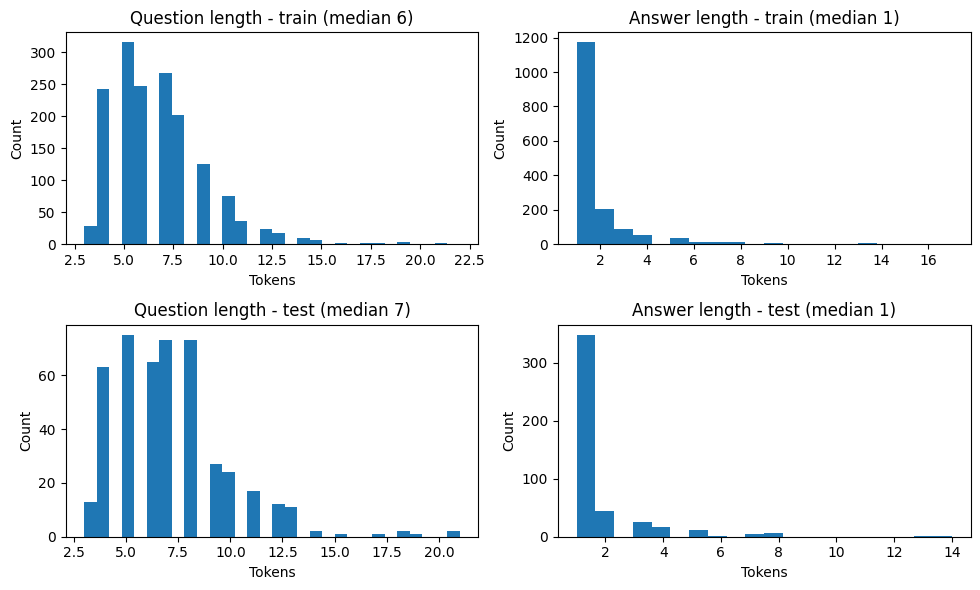

In [12]:
# Question and answer length distributions (train vs test) — compact 2x2

def lengths(s):
    return s.astype(str).str.split().str.len()

fig, axes = plt.subplots(2,2, figsize=(10,6))
pairs = [("train", train_df), ("test", test_df)]
for i,(label, d) in enumerate(pairs):
    if "question" in d.columns:
        qlens = lengths(d["question"])
        axes[i,0].hist(qlens, bins=30)
        axes[i,0].set_title(f"Question length - {label} (median {int(qlens.median())})")
        axes[i,0].set_xlabel("Tokens")
    else:
        axes[i,0].text(0.5,0.5,"no question", ha='center')
        axes[i,0].set_title(f"Question length - {label}")

    if "answer" in d.columns:
        alens = lengths(d["answer"])
        axes[i,1].hist(alens, bins=20)
        axes[i,1].set_title(f"Answer length - {label} (median {int(alens.median())})")
        axes[i,1].set_xlabel("Tokens")
    else:
        axes[i,1].text(0.5,0.5,"no answer", ha='center')
        axes[i,1].set_title(f"Answer length - {label}")

for ax in axes.flatten():
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

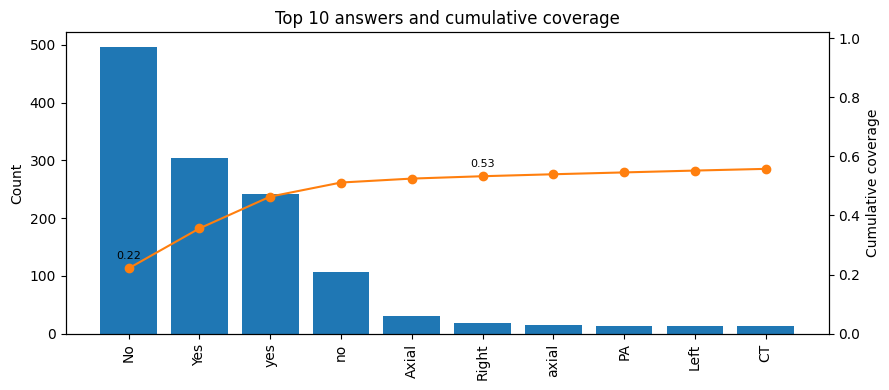

In [13]:
# Top answers + cumulative coverage line (compact dual-axis plot)

all_answers = pd.concat([train_df['answer'], val_df['answer'], test_df['answer']]).astype(str)
top_n = 10
counts = all_answers.value_counts().head(top_n)
cum = counts.cumsum() / all_answers.shape[0]

fig, ax = plt.subplots(figsize=(9,4))
ax.bar(range(len(counts)), counts.values)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, rotation=90)
ax.set_ylabel("Count")
ax.set_title(f"Top {top_n} answers and cumulative coverage")
ax2 = ax.twinx()
ax2.plot(range(len(counts)), cum.values, color='C1', marker='o', label='cumulative_coverage')
ax2.set_ylabel("Cumulative coverage")
ax2.set_ylim(0,1.02)
for i,v in enumerate(cum.values):
    if i%5==0: ax2.text(i, v+0.03, f"{v:.2f}", ha='center', fontsize=8)
plt.tight_layout()
plt.show()

## Roco

The ROCO (Radiology Objects in COntext) dataset provides a large collection of medical images with associated captions, making it ideal for domain adaptive pretraining. We filter the dataset to focus on the main medical imaging modalities (CT, MRI, X-Ray) and limit caption length to create a focused pretraining corpus that aligns with our VQA-RAD target domain.

In [14]:
# Load RocoV2 Full Dataset

ds = load_dataset("eltorio/ROCOv2-radiology")
full_dataset = concatenate_datasets([ds["train"], ds["validation"], ds["test"]])

print("Full dataset size:", len(full_dataset))

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

Full dataset size: 79793


In [15]:
# Extract Only Main Modalities (CT, MRI, X-Ray)

tokenizer = init_tokenizer()

patterns = [
    r"ct(?: scan)?",
    r"computed tomography",
    r"mri(?: scan)?",
    r"magnetic resonance(?: imaging)?",
    r"x[\s-]?ray(?:s)?",
    r"\bxr\b"
]

modality_regex = re.compile("|".join(patterns), flags=re.IGNORECASE)

max_tokens = 64

def keep_modality_and_length(batch):
    captions = batch["caption"]
    keep_mask = []
    for caption in captions:
        if not modality_regex.search(caption):
            keep_mask.append(False)
            continue
        tokens = tokenizer(caption, return_tensors="pt", truncation=False).input_ids
        if tokens.shape[1] > max_tokens:
            keep_mask.append(False)
        else:
            keep_mask.append(True)
    return {"keep": keep_mask}

ds = full_dataset.map(keep_modality_and_length, batched=True, batch_size=1000)

del full_dataset

ds_filtered = ds.filter(lambda x: x["keep"], batched=False)
ds_filtered = ds_filtered.remove_columns("keep")

del ds

print("Filtered size:", len(ds_filtered))

Filtered size: 45198


### Filtering for Medical Modalities

We filter the ROCO dataset to focus on the main medical imaging modalities (CT, MRI, X-Ray) and limit caption length for efficient training. This preprocessing step ensures we use only relevant medical imaging data for domain adaptive pretraining.

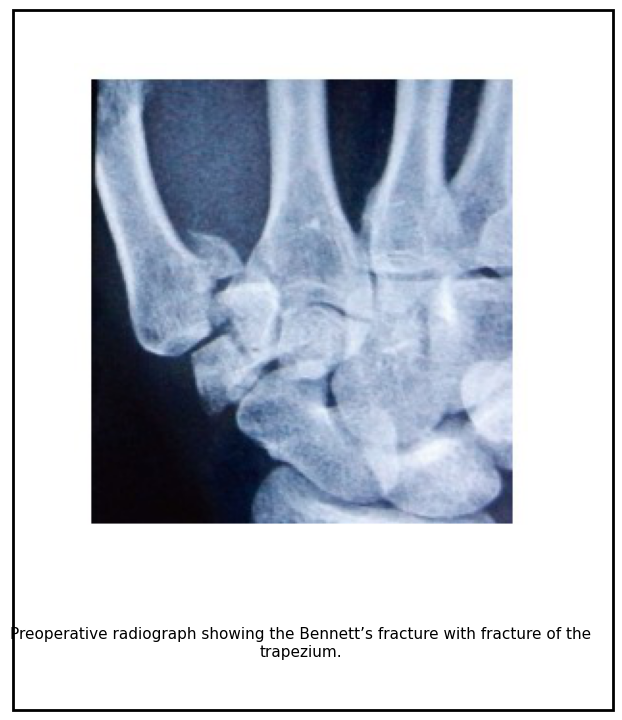

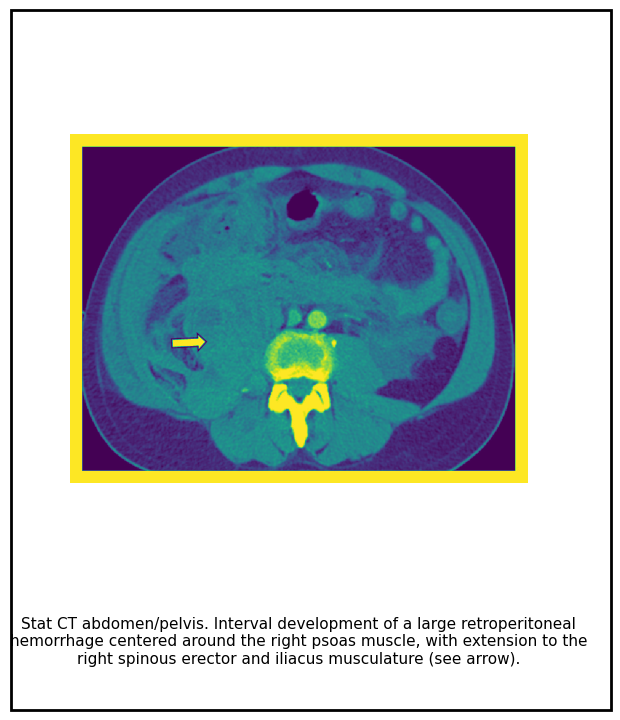

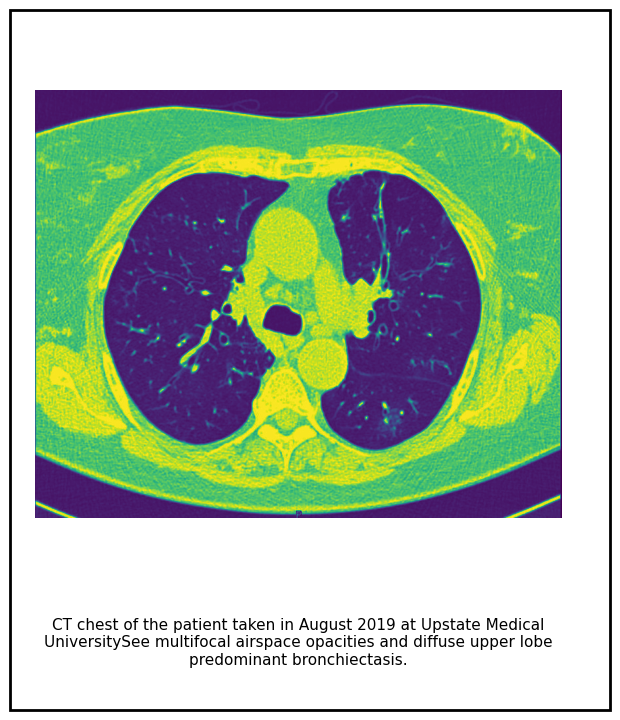

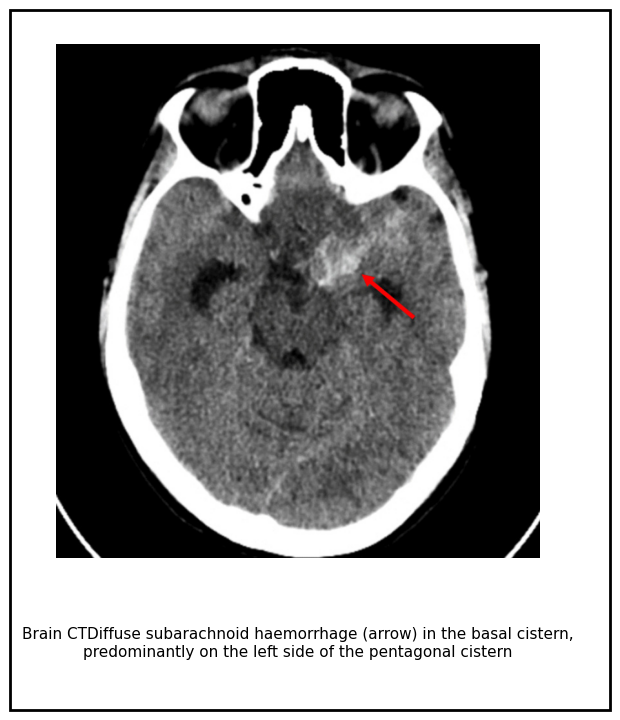

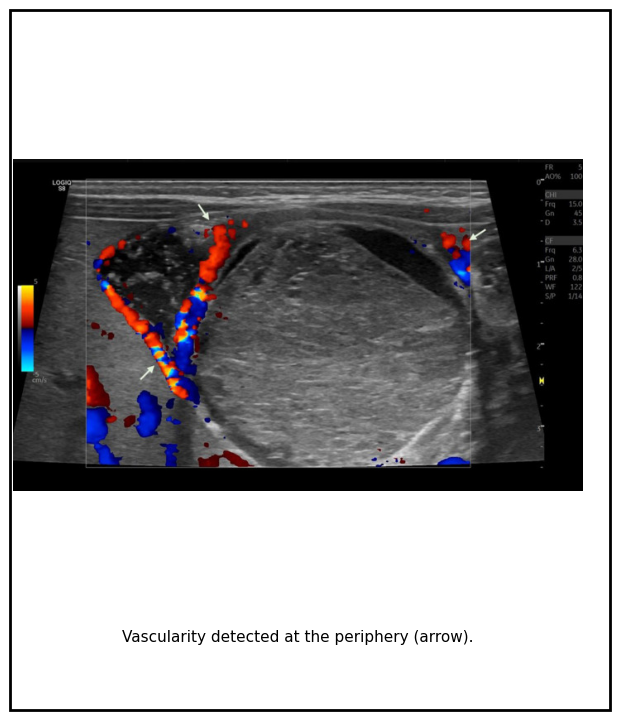

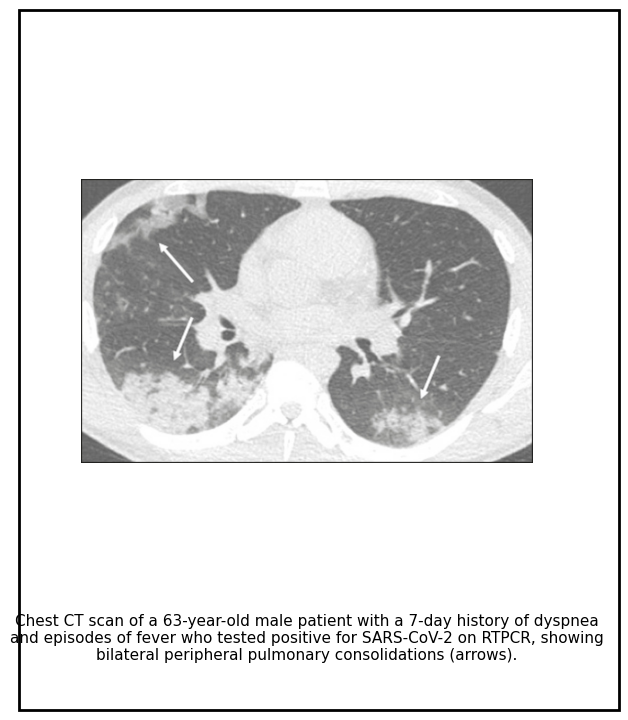

In [16]:
import matplotlib.patches as patches
def plot_examples(dataset, n=6):
    # pick random samples
    idxs = random.sample(range(len(dataset)), n)
    samples = [dataset[i] for i in idxs]

    for sample in samples:
        image = sample["image"]
        caption = sample["caption"]

        # Create a figure with 2 rows: one for image, one for caption
        fig, (ax_img, ax_cap) = plt.subplots(
            2, 1, figsize=(6, 7), gridspec_kw={'height_ratios': [4, 1]}
        )

        # Show image
        ax_img.imshow(image)
        ax_img.axis("off")

        # Show caption
        ax_cap.text(
            0.5, 0.5, caption,
            ha="center", va="center",
            wrap=True, fontsize=11
        )
        ax_cap.axis("off")

        # Add a rectangle around both subplots
        # Use figure coordinates to span the full content
        rect = patches.Rectangle(
            (0.02, 0.02), 1, 1,  # (x,y), width, height in figure coords
            transform=fig.transFigure, 
            fill=False, color="black", linewidth=2, clip_on=False
        )
        fig.patches.append(rect)

        plt.tight_layout()
        plt.show()



# Example usage
plot_examples(ds_filtered, n=6)

# Baseline

# Baseline Model & Evaluation Framework

This section establishes the baseline BLIP model and the evaluation methodology. We implement multiple metrics including exact match accuracy, edit similarity, and analysis by answer type, and organ system to assess VQA performance.

## Evaluation

In [17]:
class VQARADDatasetEval(Dataset):
    def __init__(self, data_list, metadata_keys=None):
        self._data = data_list
        self.metadata_keys = metadata_keys or []

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        sample = self._data[idx]

        image = sample["image"]
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")

        item = {
            "image": image,
            "question": sample["question"],
            "answer": sample["answer"]
        }

        for key in self.metadata_keys:
            if key in sample:
                item[key] = sample[key]

        return item

In [18]:
# BLIP preprocessing

blip_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                         (0.26862954, 0.26130258, 0.27577711))
])

In [19]:
def pil_collate(batch):
    return {key: [d[key] for d in batch] for key in batch[0]}

In [20]:
# Create Datasets and Loaders

metadata_keys = ['phrase_type', 'question_type', 'answer_type', 'image_organ']

test_dataset  = VQARADDatasetEval(dataset['test'], metadata_keys=metadata_keys)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pil_collate)

In [21]:
# --- normalization and exact match ---
def normalize_text(s):
    if s is None:
        return ""
    s = str(s).lower().strip()
    s = re.sub(r"[^\w\s]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

def exact_match_norm(pred, gt):
    return normalize_text(pred) == normalize_text(gt)

def edit_sim(pred, gt):
    return SequenceMatcher(None, normalize_text(pred), normalize_text(gt)).ratio()

# --- evaluation ---
def evaluate_vqa(dataloader, model, device):
    model.eval()
    model.to(device)

    total = correct = 0
    closed_total = closed_correct = 0
    open_total = open_correct = 0
    errors = []

    # edit sim aggregates
    edit_total = edit_closed = edit_open = 0.0

    # per qtype / organ
    type_totals = defaultdict(int)
    type_corrects = defaultdict(int)
    type_edit_sums = defaultdict(float)

    organ_totals = defaultdict(int)
    organ_corrects = defaultdict(int)
    organ_edit_sums = defaultdict(float)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating VQA"):
            images = batch['image']
            questions = batch['question']
            gt_answers = batch['answer']
            answer_types = batch.get('answer_type', ['CLOSED'] * len(gt_answers))

            img_tensors = torch.stack([blip_transform(img) for img in images], dim=0).to(device)
            preds = model(img_tensors, questions, train=False, inference='generate')

            for i, (pred, question, gt, ans_type) in enumerate(zip(preds, questions, gt_answers, answer_types)):
                total += 1
                is_correct = exact_match_norm(pred, gt)

                if is_correct:
                    correct += 1

                e = edit_sim(pred, gt)
                edit_total += e

                if ans_type.upper() == "CLOSED":
                    closed_total += 1
                    if is_correct:
                        closed_correct += 1
                    edit_closed += e
                else:
                    open_total += 1
                    if is_correct:
                        open_correct += 1
                    edit_open += e

                q_type = batch.get('question_type', [None] * len(gt_answers))[i]
                if q_type:
                    type_totals[q_type] += 1
                    if is_correct:
                        type_corrects[q_type] += 1
                    type_edit_sums[q_type] += e

                organ = batch.get('image_organ', [None] * len(gt_answers))[i]
                if organ:
                    organ_totals[organ] += 1
                    if is_correct:
                        organ_corrects[organ] += 1
                    organ_edit_sums[organ] += e

                if not is_correct:
                    err = {
                        'question': question,
                        'ground_truth': gt,
                        'prediction': pred
                    }
                    for key in ['question_type', 'answer_type', 'image_organ']:
                        if key in batch:
                            err[key] = batch[key][i]
                    errors.append(err)

    metrics = {
        'overall': {
            'accuracy': correct / total if total else 0,
            'edit': edit_total / total if total else 0,
            'count': total
        },
        'closed': {
            'accuracy': closed_correct / closed_total if closed_total else 0,
            'edit': edit_closed / closed_total if closed_total else 0,
            'count': closed_total
        },
        'open': {
            'accuracy': open_correct / open_total if open_total else 0,
            'edit': edit_open / open_total if open_total else 0,
            'count': open_total
        },
        'per_qtype': {
            q: {
                'accuracy': type_corrects[q] / type_totals[q],
                'edit': type_edit_sums[q] / type_totals[q],
                'count': type_totals[q]
            } for q in type_totals
        },
        'per_organ': {
            o: {
                'accuracy': organ_corrects[o] / organ_totals[o],
                'edit': organ_edit_sums[o] / organ_totals[o],
                'count': organ_totals[o]
            } for o in organ_totals
        },
        'errors': errors
    }

    return metrics


In [22]:
def plot_vqa_summary(metrics):
    metrics_list = ['accuracy', 'edit']   # only accuracy + edit

    total_qs = metrics['overall'].get('count', 0)
    closed_qs = metrics['closed'].get('count', 0)
    open_qs = metrics['open'].get('count', 0)

    overall_vals = {m: metrics['overall'].get(m,0) for m in metrics_list}
    closed_vals  = {m: metrics['closed'].get(m,0)  for m in metrics_list}
    open_vals    = {m: metrics['open'].get(m,0)    for m in metrics_list}

    # --- Question types ---
    df_qtype = pd.DataFrame.from_dict(metrics.get('per_qtype', {}), orient='index')
    if not df_qtype.empty:
        # Drop rows with no values for accuracy/edit
        df_qtype = df_qtype.dropna(subset=metrics_list, how="all")
        df_qtype = df_qtype[(df_qtype[metrics_list] != 0).any(axis=1)]
        macro_qtype = df_qtype[metrics_list].mean()
    else:
        macro_qtype = {m:0 for m in metrics_list}

    # --- Organs ---
    df_organ = pd.DataFrame.from_dict(metrics.get('per_organ', {}), orient='index')
    if not df_organ.empty:
        # Drop rows with no values for accuracy/edit
        df_organ = df_organ.dropna(subset=metrics_list, how="all")
        df_organ = df_organ[(df_organ[metrics_list] != 0).any(axis=1)]
        macro_organ = df_organ[metrics_list].mean()
    else:
        macro_organ = {m:0 for m in metrics_list}

    n_errors = len(metrics.get('errors', [])) if metrics.get('errors') else 0

    # --- Print summary ---
    print("\n================ VQA-RAD KEY STATISTICS ================\n")
    print(f"{'Metric':25} | {'Value'}")
    print("-"*40)
    print(f"{'Total Questions':25} | {total_qs}")
    print(f"{'Closed Questions':25} | {closed_qs}")
    print(f"{'Open Questions':25}   | {open_qs}")
    print("-"*40)
    for m in metrics_list:
        print(f"{'Overall ' + m.upper():25} | {overall_vals[m]:.3f}")
        print(f"{'Closed ' + m.upper():25}  | {closed_vals[m]:.3f}")
        print(f"{'Open ' + m.upper():25}    | {open_vals[m]:.3f}")
    print("-"*40)
    for m in metrics_list:
        print(f"{'Macro Question Type ' + m.upper():25} | {macro_qtype[m]:.3f}")
        print(f"{'Macro Organ ' + m.upper():25}            | {macro_organ[m]:.3f}")
    print(f"{'Total Errors':25} | {n_errors}")
    print("\n========================================================\n")

    # --- Plot ---
    fig, axes = plt.subplots(1, 3, figsize=(24,8))  # bigger plots

    # 1. Grouped bar plot for Overall / Closed / Open
    df_overall = pd.DataFrame({
        'Overall': overall_vals,
        'Closed': closed_vals,
        'Open': open_vals
    })
    df_overall.plot(kind="bar", ax=axes[0], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    axes[0].set_ylim(0,1)
    axes[0].set_title("Overall / Closed / Open")
    axes[0].set_ylabel("Score")
    axes[0].legend(title="Set")

    # 2. Bar plot for all question types
    if not df_qtype.empty:
        df_qtype[metrics_list].plot(kind="bar", ax=axes[1], color=["#4daf4a", "#377eb8"])
        axes[1].set_ylim(0,1)
        axes[1].set_title("All Question Types")
        axes[1].set_ylabel("Score")
        axes[1].legend(title="Metric")
        axes[1].tick_params(axis='x', rotation=30)

    # 3. Bar plot for all organs
    if not df_organ.empty:
        df_organ[metrics_list].plot(kind="bar", ax=axes[2], color=["#984ea3", "#ff7f00"])
        axes[2].set_ylim(0,1)
        axes[2].set_title("All Organs")
        axes[2].set_ylabel("Score")
        axes[2].legend(title="Metric")
        axes[2].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()


## Fine Tuning

We fine-tune the pretrained BLIP model on VQA-RAD using a frozen vision encoder approach where only text components are updated. The training includes early stopping based on validation loss, gradient clipping for stability, and cosine annealing learning rate scheduling.

In [23]:
# Load Pretrained-Only Model (No Task Specific Fine Tuning)

checkpoint_path = "/kaggle/input/pretrained-only-blip-ckpt/model_base_capfilt_large.pth"
baseline_model = blip_vqa(pretrained=checkpoint_path, image_size=224, vit='base')
baseline_model = baseline_model.to(device)

load checkpoint from /kaggle/input/pretrained-only-blip-ckpt/model_base_capfilt_large.pth


In [24]:
# Print Params

total_params = sum(p.numel() for p in baseline_model.parameters())
trainable_params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}\n")

Total parameters: 360,938,300
Trainable parameters: 360,938,300



In [25]:
class VQARADDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            'image': item['image'],
            'question': item['question'],
            'answer': item['answer']
        }

def collate_fn(batch, processor):
    images = torch.stack([processor(b['image']) for b in batch])
    questions = [b['question'] for b in batch]
    answers = [b['answer'] for b in batch]
    return {
        'image': images,
        'question': questions,
        'answer': answers
    }

In [26]:
train_dataset = VQARADDataset(dataset['train'])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda b: collate_fn(b, blip_transform), drop_last=True)

val_dataset = VQARADDataset(dataset['validation'])
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, collate_fn=lambda b: collate_fn(b, blip_transform), drop_last=True)

In [27]:

def train_blip_vqa(model, train_loader, val_loader, ft_config, device, output_dir, model_path):
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=ft_config['init_lr'], weight_decay=ft_config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ft_config['epochs'], eta_min=ft_config['eta_min'])

    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    os.makedirs(output_dir, exist_ok=True)

    if ft_config['freeze_vision']:
        for param in model.visual_encoder.parameters():
            param.requires_grad = False
        print("Visual encoder frozen.")

    for epoch in range(ft_config['epochs']):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch} Training"):
            images = batch['image'].to(device)
            questions = batch['question']
            answers = batch['answer']
            batch_size = images.size(0)
            n = [1] * batch_size
            weights = torch.ones(batch_size, device=device)

            loss = model(images, questions, answers, n=n, weights=weights, train=True)
            optimizer.zero_grad()
            loss.backward()
            if ft_config.get('max_grad_norm', None):
                torch.nn.utils.clip_grad_norm_(model.parameters(), ft_config['max_grad_norm'])
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch} Validation"):
                images = batch['image'].to(device)
                questions = batch['question']
                answers = batch['answer']
                batch_size = images.size(0)
                n = [1] * batch_size
                weights = torch.ones(batch_size, device=device)

                loss = model(images, questions, answers, n=n, weights=weights, train=True)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch}: Val Loss = {avg_val_loss:.4f}")

        scheduler.step()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch
            patience_counter = 0
            best_model_path = os.path.join(output_dir, model_path)
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved Best Model at Epoch {epoch}")
        else:
            patience_counter += 1
            if patience_counter >= ft_config.get('early_stop_patience', 3): 
                print(f"Early stopping at epoch {epoch}")
                break

    print(f"Training finished. Best epoch: {best_epoch}, Best val loss: {best_val_loss:.4f}")

In [28]:
# Fine Tuning

train_blip_vqa(baseline_model, train_loader, val_loader, ft_config, device, ft_config.get('model_dir'), ft_config.get('model_path'))

Visual encoder frozen.


Epoch 0 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0: Train Loss = 16.0266


Epoch 0 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 0: Val Loss = 14.0362
Saved Best Model at Epoch 0


Epoch 1 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Train Loss = 12.3271


Epoch 1 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1: Val Loss = 12.7466
Saved Best Model at Epoch 1


Epoch 2 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Train Loss = 10.6701


Epoch 2 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 2: Val Loss = 12.0078
Saved Best Model at Epoch 2


Epoch 3 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Train Loss = 9.3916


Epoch 3 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 3: Val Loss = 11.5239
Saved Best Model at Epoch 3


Epoch 4 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Train Loss = 8.4566


Epoch 4 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 4: Val Loss = 11.2129
Saved Best Model at Epoch 4


Epoch 5 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Train Loss = 7.6881


Epoch 5 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 5: Val Loss = 11.1140
Saved Best Model at Epoch 5


Epoch 6 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Train Loss = 7.0956


Epoch 6 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 6: Val Loss = 10.8103
Saved Best Model at Epoch 6


Epoch 7 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Train Loss = 6.7368


Epoch 7 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 7: Val Loss = 10.9037


Epoch 8 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Train Loss = 6.4259


Epoch 8 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 8: Val Loss = 10.6312
Saved Best Model at Epoch 8


Epoch 9 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Train Loss = 6.1529


Epoch 9 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 9: Val Loss = 10.7967


Epoch 10 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Train Loss = 6.0107


Epoch 10 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 10: Val Loss = 10.6360


Epoch 11 Training:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11: Train Loss = 5.8806


Epoch 11 Validation:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 11: Val Loss = 10.7163
Early stopping at epoch 11
Training finished. Best epoch: 8, Best val loss: 10.6312


In [29]:
# Initialize a new VQA model

eval_model = blip_vqa(pretrained=None, image_size=224, vit='base')

best_model_path = os.path.join(ft_config.get('model_dir'), ft_config.get('model_path'))
state_dict = torch.load(best_model_path, map_location=device)

eval_model.load_state_dict(state_dict)

<All keys matched successfully>

In [30]:
# Evaluation

metrics = evaluate_vqa(test_loader, eval_model, device)

Evaluating VQA:   0%|          | 0/29 [00:00<?, ?it/s]


================ VQA-RAD KEY STATISTICS ================

Metric                    | Value
----------------------------------------
Total Questions           | 462
Closed Questions          | 271
Open Questions              | 191
----------------------------------------
Overall ACCURACY          | 0.662
Closed ACCURACY            | 0.782
Open ACCURACY                | 0.492
Overall EDIT              | 0.754
Closed EDIT                | 0.792
Open EDIT                    | 0.700
----------------------------------------
Macro Question Type ACCURACY | 0.630
Macro Organ ACCURACY                 | 0.663
Macro Question Type EDIT  | 0.792
Macro Organ EDIT                     | 0.755
Total Errors              | 156




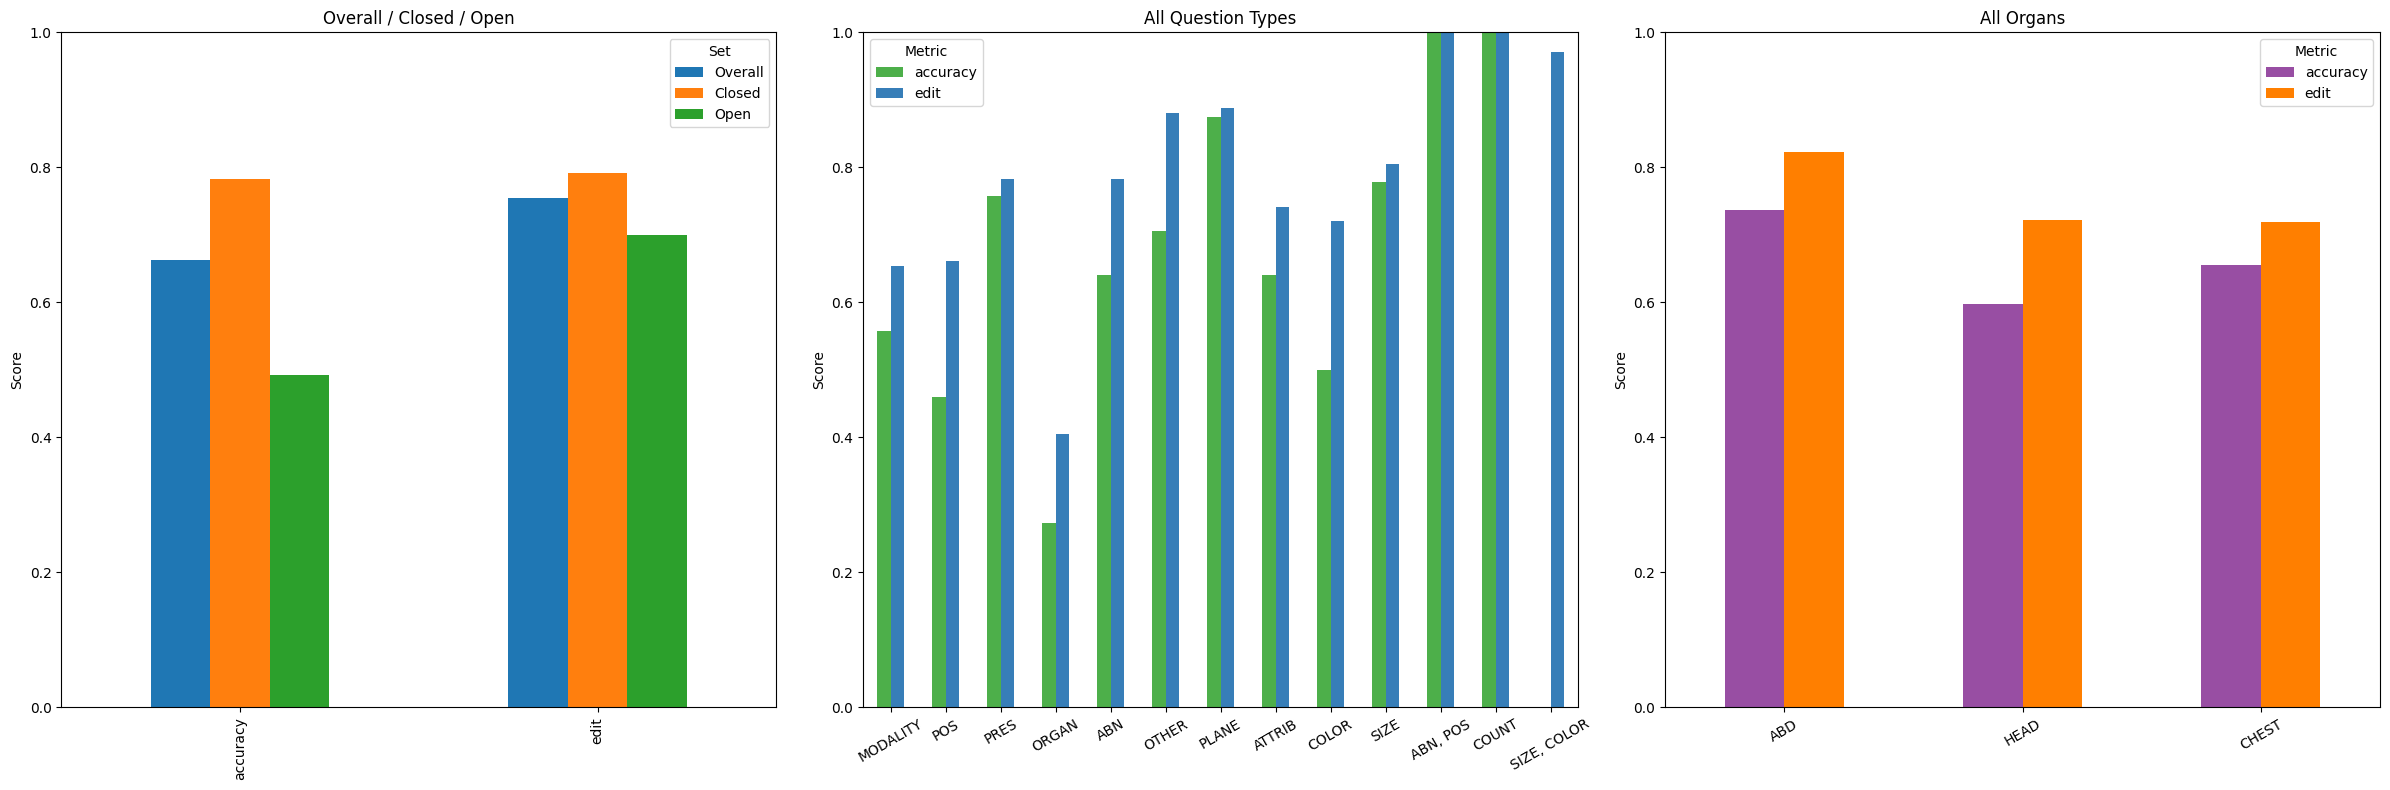

In [31]:
# Plotting

plot_vqa_summary(metrics)

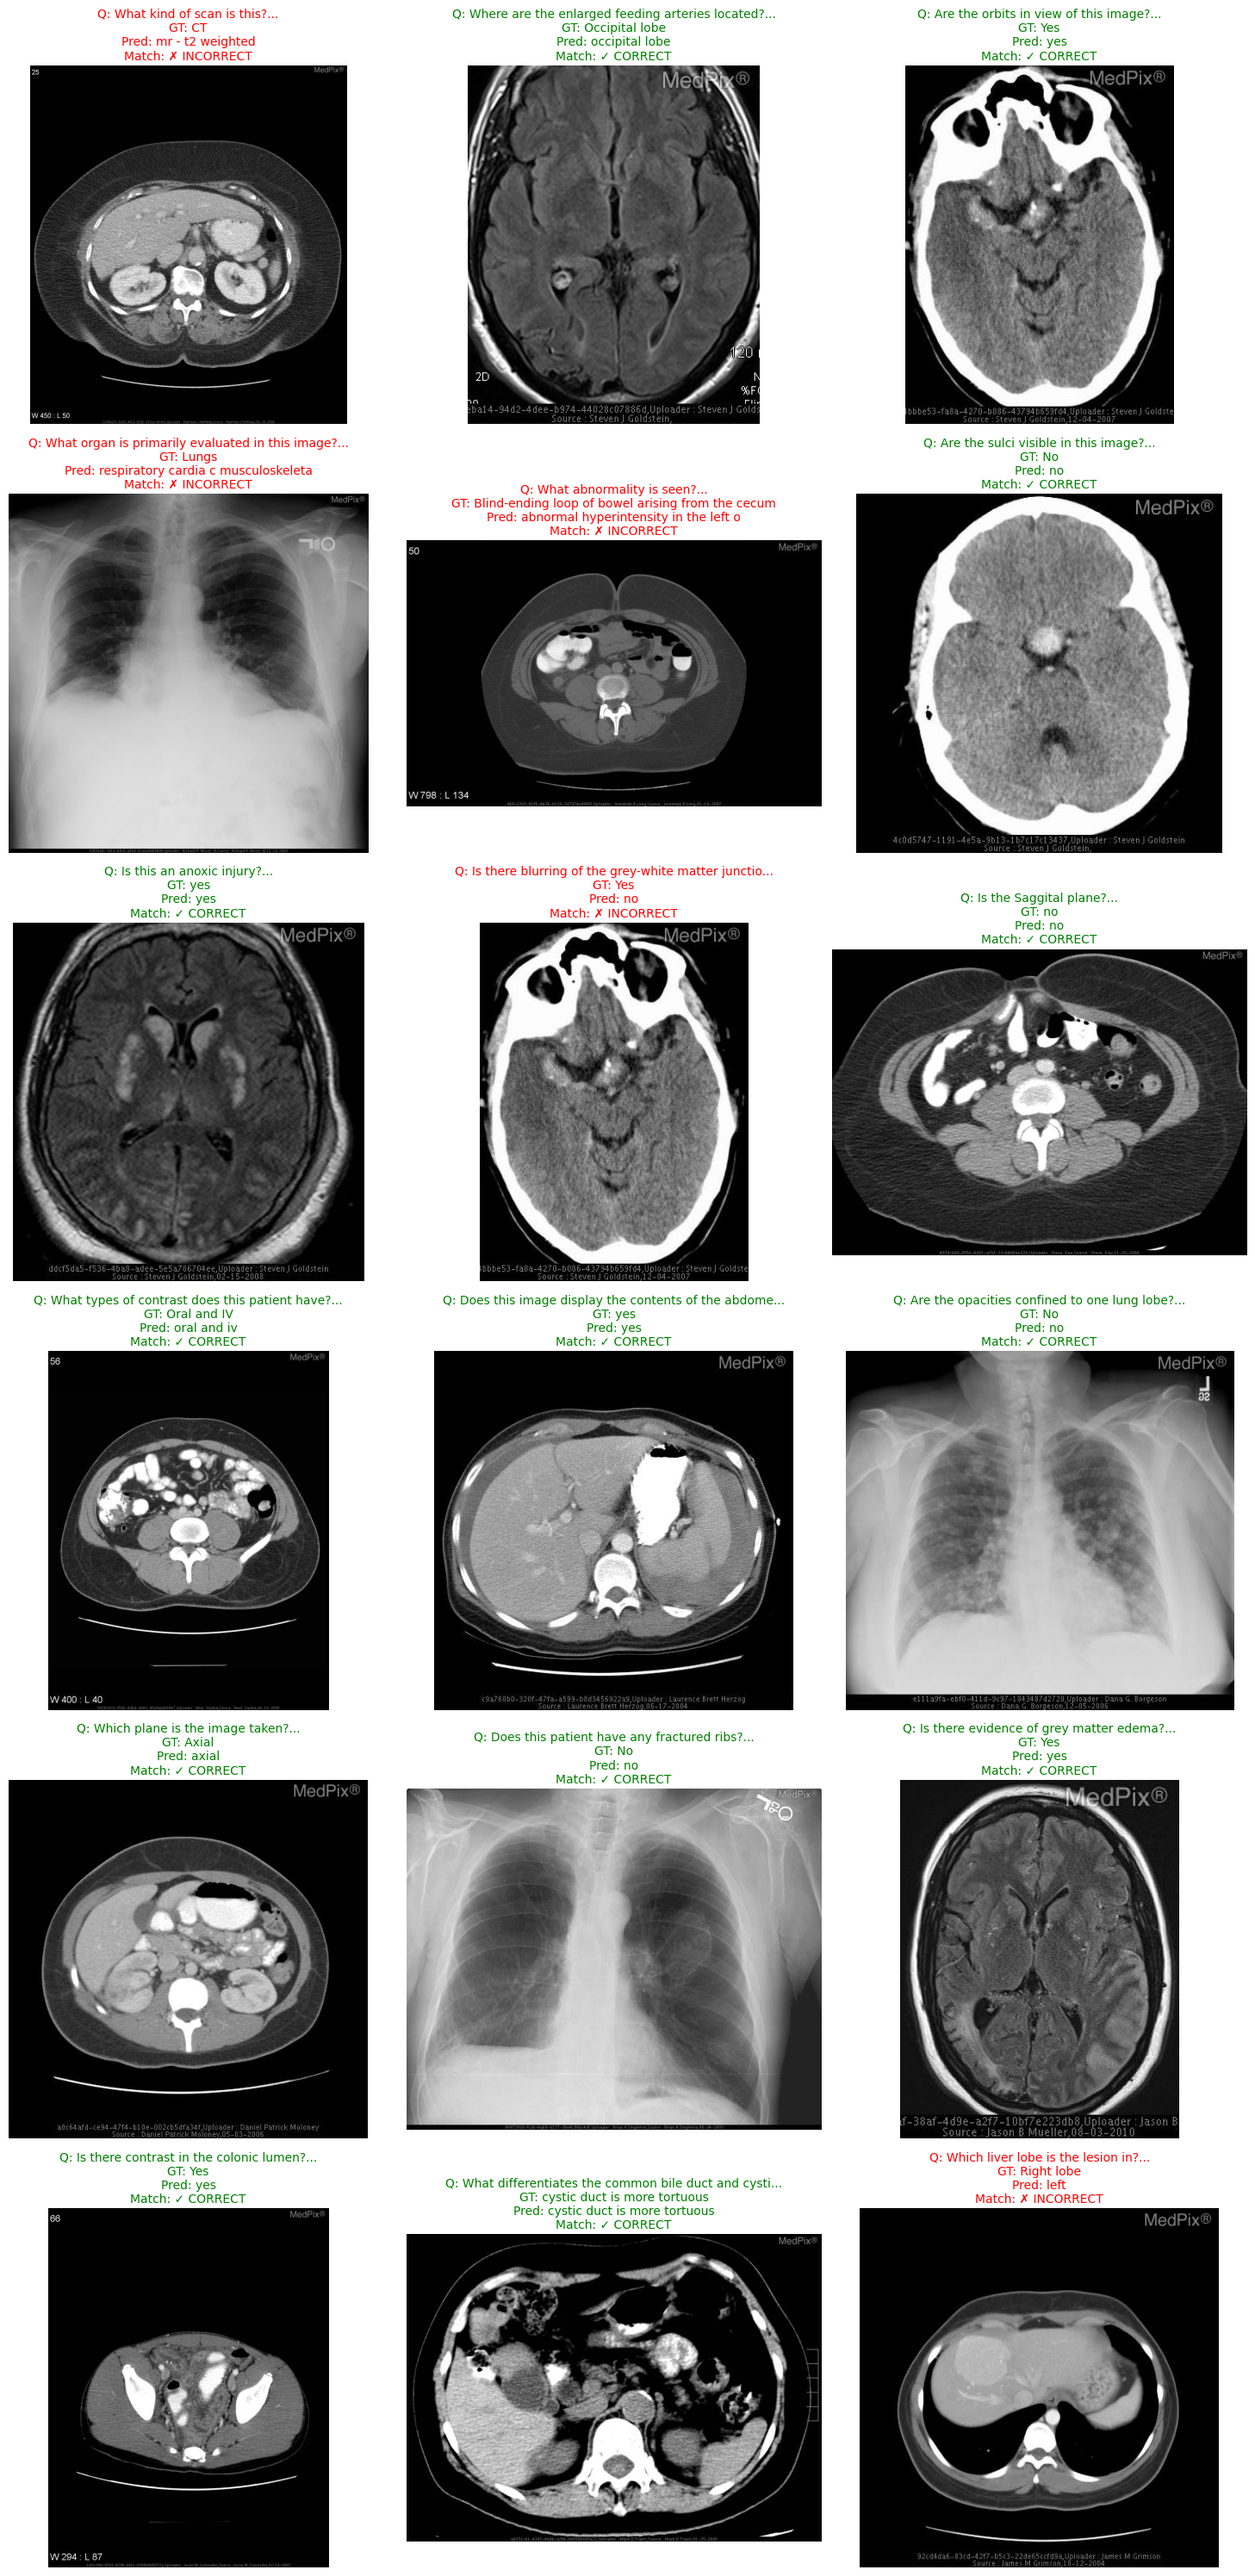

In [32]:
def plot_examples(dataloader, model, device, num_examples=6):
    model.eval()
    model.to(device)
    
    examples = []
    with torch.no_grad():
        for batch in dataloader:
            if len(examples) >= num_examples:
                break
                
            images = batch['image']
            questions = batch['question']
            gt_answers = batch['answer']
            
            img_tensors = torch.stack([blip_transform(img) for img in images], dim=0).to(device)
            preds = model(img_tensors, questions, train=False, inference='generate')
            
            for img, q, gt, pred in zip(images, questions, gt_answers, preds):
                if len(examples) >= num_examples:
                    break
                examples.append({
                    'image': img,
                    'question': q,
                    'ground_truth': gt,
                    'prediction': pred
                })
    
    # Dynamic subplot layout
    n = len(examples)
    cols = min(3, n)  # up to 3 per row
    rows = math.ceil(n / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, example in enumerate(examples):
        axes[i].imshow(example['image'])
        axes[i].axis('off')
        
        # Check if prediction matches ground truth
        is_correct = exact_match_norm(example['prediction'], example['ground_truth'])
        match_status = "✓ CORRECT" if is_correct else "✗ INCORRECT"
        
        title = f"Q: {example['question'][:50]}...\n"
        title += f"GT: {example['ground_truth']}\n"
        title += f"Pred: {example['prediction']}\n"
        title += f"Match: {match_status}"
        
        # Color the title based on correctness
        title_color = 'green' if is_correct else 'red'
        axes[i].set_title(title, fontsize=10, wrap=True, color=title_color)
    
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()


# Plot examples using the evaluation model
plot_examples(test_loader, eval_model, device, num_examples=18)


In [33]:
# Clear Memory

del baseline_model
del eval_model
del state_dict
torch.cuda.empty_cache()

# Experiments

## Domain Adaptive Pretraining

# Domain Adaptive Pretraining (DAPT) Experiments

This section implements domain adaptive pretraining using the filtered ROCO medical dataset. We use a teacher-student architecture with dynamic task weighting to adapt BLIP to the medical domain.

## Focused Multi-Task Distillation

Our approach uses:
- **Teacher-Student Architecture**: EMA teacher provides stable training targets
- **Dynamic Task Weighting**: Adaptive weighting based on student-teacher performance ratios  
- **Multi-Task Learning**: Joint training on image-text contrastive (ITC), image-text matching (ITM), and language modeling (LM) objectives

The distillation process dynamically focuses computational resources on tasks where the student model is struggling most relative to the teacher.

In [34]:

checkpoint_path = "/kaggle/input/pretrained-only-blip-ckpt/model_base_capfilt_large.pth"

model = blip_pretrain(
    image_size= dapt_config['image_size'],
    vit='base',
    queue_size= dapt_config['queue_size'],
    vit_grad_ckpt=dapt_config['vit_grad_ckpt']
)

import sys
mod_name = model.__class__.__module__
mod = sys.modules[mod_name]
print("Patching module:", mod_name, mod)

def concat_all_gather_single(tensor):
    return tensor

mod.concat_all_gather = concat_all_gather_single
print("Patched module.concat_all_gather ->", mod.concat_all_gather)

pretrained_ckpt = torch.load(checkpoint_path, map_location=device)
state_dict = pretrained_ckpt.get('model', pretrained_ckpt)

for k in list(state_dict.keys()):
    kl = k.lower()
    if 'image_queue' in kl or 'text_queue' in kl or 'queue_ptr' in kl or (('queue' in kl) and ('momentum' not in kl)):
        state_dict.pop(k, None)

res = model.load_state_dict(state_dict, strict=False)
print("load_state_dict result:", res)

with torch.no_grad():
    for name, buf in model.named_buffers():
        n = name.lower()
        if 'queue' in n:
            buf.zero_()
            print(f"Zeroed buffer {name}, shape {tuple(buf.shape)}")
        if 'ptr' in n or 'queue_ptr' in n:
            try:
                buf.zero_()
                print(f"Zeroed pointer buffer {name}")
            except Exception:
                # some ptrs might not be buffers; skip safely
                pass

Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth
100%|██████████| 330M/330M [00:01<00:00, 197MB/s] 


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/embeddings/word_embeddings is tied
/embeddings/position_embeddings is tied
/embeddings/LayerNorm is tied
/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
/encoder/layer/2/crossattention/self/query is tied
/encoder/layer/2/crossattention/self/key is tied
/encoder/layer/2/crossat

In [35]:
# Simple epoch-based DAPT that saves only final model
from PIL import Image

class HFIterableROCO(IterableDataset):
    def __init__(self, hf_dataset, transform=None, shuffle_buffer=0):
        self.ds = hf_dataset
        self.transform = transform if transform is not None else blip_transform
        self.shuffle_buffer = int(shuffle_buffer)

    def _prepare_image(self, image):
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        return self.transform(image)

    def __iter__(self):
        it = iter(self.ds)
        if self.shuffle_buffer <= 0:
            for item in it:
                yield self._prepare_image(item['image']), item['caption']
        else:
            buf = []
            for item in it:
                buf.append((self._prepare_image(item['image']), item['caption']))
                if len(buf) >= self.shuffle_buffer:
                    idx = random.randrange(len(buf))
                    yield buf.pop(idx)
            random.shuffle(buf)
            for x in buf:
                yield x

def collate_simple(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(captions)

In [36]:
import os, math, time, copy
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import torch
import numpy as np

class FocusedMultiTaskDistillation:
    def __init__(self, epsilon=1e-8, smoothing=0.9):
        self.epsilon = epsilon
        self.smoothing = smoothing
        self.running_ratios = {'itc': 1.0, 'itm': 1.0, 'lm': 1.0}
        self.task_history = {'itc': [], 'itm': [], 'lm': []}
    
    def compute_weights(self, student_losses, teacher_losses):
        """Compute dynamic weights based on student-teacher performance ratio"""
        weights = {}
        
        for task in ['itc', 'itm', 'lm']:
            # Compute current ratio (high ratio = student struggling)
            current_ratio = student_losses[task] / (teacher_losses[task] + self.epsilon)
            self.task_history[task].append(current_ratio.item())
            
            # Exponential smoothing to reduce noise
            self.running_ratios[task] = (
                self.smoothing * self.running_ratios[task] + 
                (1 - self.smoothing) * current_ratio
            )
            
            # Clamp ratios to prevent extreme values
            clamped_ratio = torch.clamp(self.running_ratios[task], 0.1, 5.0)
            weights[task] = clamped_ratio
        
        # Softmax normalization for stable gradients
        weight_tensor = torch.tensor([weights['itc'].item(), weights['itm'].item(), weights['lm'].item()])
        normalized_weights = F.softmax(weight_tensor, dim=0)
        
        return {
            'itc': normalized_weights[0],
            'itm': normalized_weights[1], 
            'lm': normalized_weights[2]
        }


In [37]:
def dapt_roco_epochs_psd(
    model,
    ds_filtered,
    device='cuda',
    config=None
):
    os.makedirs(config['output_dir'], exist_ok=True)
    device = torch.device(device)
    model.to(device)
    model.train()
    
    print("🚀 Starting Medical DAPT with Focused Multi-Task Distillation")
    print(f"📊 Dataset size: {len(ds_filtered)} samples")

    # Initialize EMA teacher
    teacher_model = copy.deepcopy(model)
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False

    # Initialize focused distillation manager
    distillation_manager = FocusedMultiTaskDistillation()

    dataset_len = len(ds_filtered)
    batches_per_epoch = dataset_len // config['batch_size']
    steps_per_epoch = batches_per_epoch // config['grad_accum_steps']
    
    print(f"📈 Batches per epoch: {batches_per_epoch}")
    print(f"📈 Steps per epoch: {steps_per_epoch}")

    # Create optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['warmup_lr'], weight_decay=config['weight_decay'])
    scaler = GradScaler()
    
    global_step = 0
    best_loss = float('inf')
    training_history = []   # epoch-level summary
    batch_history = []      # batch-level logging
    
    # Create data loader
    iterable_ds = HFIterableROCO(ds_filtered, transform=blip_transform, 
                                shuffle_buffer=config['shuffle_buffer'])
    train_loader = DataLoader(
        iterable_ds,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        collate_fn=collate_simple,
        drop_last=True
    )

    for epoch in range(config['num_epochs']):
        epoch_losses = []
        batch_count = 0
        
        print(f"\n🎯 Epoch {epoch+1}/{config['num_epochs']}")
        
        with tqdm(total=batches_per_epoch, desc=f"Epoch {epoch+1}", unit="batch") as pbar:
            accum_counter = 0
            
            for batch_idx, (images, captions) in enumerate(train_loader):
                if batch_idx >= batches_per_epoch:
                    break
                    
                # --- Learning rate schedule ---
                if epoch == 0:
                    # Linear warmup for first epoch
                    current_lr = config['warmup_lr'] + (config['lr'] - config['warmup_lr']) * min(1.0, batch_idx / batches_per_epoch)
                else:
                    # Cosine decay for subsequent epochs
                    progress = (epoch + batch_idx / batches_per_epoch) / config['num_epochs']
                    current_lr = config['min_lr'] + 0.5 * (config['lr'] - config['min_lr']) * (1 + math.cos(math.pi * progress))
                for param_group in optimizer.param_groups:
                    param_group['lr'] = current_lr

                images = images.to(device, non_blocking=True)

                epoch_progress = (epoch + batch_idx / batches_per_epoch) / config['num_epochs']
                curr_tau = 0.95 + (config['tau'] - 0.95) * min(1.0, epoch_progress * 2)
                
                # ----- Teacher-Student Forward Passes -----
                with torch.no_grad():
                    teacher_loss_ita, teacher_loss_itm, teacher_loss_lm = teacher_model(images, captions, config['alpha'])

                with autocast('cuda'):
                    # Student forward
                    student_loss_ita, student_loss_itm, student_loss_lm = model(images, captions, config['alpha'])

                    # ----- Adaptive Multi-Task Distillation -----
                    student_losses = {'itc': student_loss_ita, 'itm': student_loss_itm, 'lm': student_loss_lm}
                    teacher_losses = {'itc': teacher_loss_ita, 'itm': teacher_loss_itm, 'lm': teacher_loss_lm}
                    
                    weights = distillation_manager.compute_weights(student_losses, teacher_losses)
                    
                    # Weighted distillation losses
                    distill_loss_ita = F.mse_loss(student_loss_ita, teacher_loss_ita) * weights['itc']
                    distill_loss_itm = F.mse_loss(student_loss_itm, teacher_loss_itm) * weights['itm']
                    distill_loss_lm = F.mse_loss(student_loss_lm, teacher_loss_lm) * weights['lm']

                    total_distill_loss = distill_loss_ita + distill_loss_itm + distill_loss_lm

                    # Combined loss
                    task_loss = student_loss_ita + student_loss_itm + student_loss_lm
                    total_loss = task_loss + total_distill_loss

                # Gradient accumulation
                scaler.scale(total_loss / config['grad_accum_steps']).backward()
                accum_counter += 1
                epoch_losses.append(total_loss.item())

                if accum_counter >= config['grad_accum_steps']:
                    # Gradient clipping
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.get('max_grad_norm', 1.0))
                    
                    # Optimizer step
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    accum_counter = 0
                    
                    # EMA teacher update
                    with torch.no_grad():
                        for teacher_param, student_param in zip(teacher_model.parameters(), model.parameters()):
                            teacher_param.data.mul_(curr_tau).add_(student_param.data * (1 - curr_tau))
                    
                    global_step += 1
                
                # save per-batch stats
                batch_history.append({
                    "epoch": epoch + 1,
                    "batch": batch_idx + 1,
                    "loss": total_loss.item(),
                    "lr": float(current_lr),
                    "weights": {k: float(v.item()) for k, v in weights.items()}
                })
                
                # Update progress bar
                batch_count += 1
                pbar.update(1)
                pbar.set_postfix({
                    "LR": f"{current_lr:.1e}",
                    "Loss": f"{total_loss.item():.4f}",
                    "W_ITC": f"{weights['itc'].item():.2f}",
                    "W_ITM": f"{weights['itm'].item():.2f}", 
                    "W_LM": f"{weights['lm'].item():.2f}",
                })
                
        # Epoch statistics
        avg_epoch_loss = np.mean(epoch_losses) if epoch_losses else 0
        print(f"📊 Epoch {epoch+1} completed: Average Loss = {avg_epoch_loss:.4f}")
        print(f"   Processed {batch_count} batches")
        
        # Save checkpoint every epoch
        ckpt_path = os.path.join(config['output_dir'], "checkpoint_dapt_psd.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, ckpt_path)
        print(f"💾 Checkpoint saved: {ckpt_path}")

    # Save per-batch loss log to JSON
    log_path = os.path.join(config['output_dir'], "batch_history.json")
    with open(log_path, "w") as f:
        json.dump(batch_history, f, indent=2)
    print(f"📝 Batch history saved: {log_path}")

    print(f"\n✅ Training finished! Total epochs: {config['num_epochs']}")
    del teacher_model
    
    return batch_history


# Helper function to analyze and plot logs
def analyze_training_log(json_path):
    with open(json_path, "r") as f:
        history = json.load(f)
    
    losses = [entry["loss"] for entry in history]
    epochs = [entry["epoch"] for entry in history]
    batches = [entry["batch"] for entry in history]
    
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)
    print(f"📊 Mean loss: {mean_loss:.4f}, Std: {std_loss:.4f}")
    
    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(range(len(losses)), losses, label="Batch Loss")
    plt.xlabel("Batch Index (across epochs)")
    plt.ylabel("Loss")
    plt.title("Training Loss per Batch")
    plt.legend()
    plt.show()
    
    return {"mean": mean_loss, "std": std_loss, "history": history}


In [38]:
# Now call training

dapt_roco_epochs_psd(model, ds_filtered, config=dapt_config)

🚀 Starting Medical DAPT with Focused Multi-Task Distillation
📊 Dataset size: 45198 samples
📈 Batches per epoch: 2824
📈 Steps per epoch: 706

🎯 Epoch 1/2


Epoch 1:   0%|          | 0/2824 [00:00<?, ?batch/s]

📊 Epoch 1 completed: Average Loss = 13.4798
   Processed 2824 batches
💾 Checkpoint saved: dapt_roco_psd/checkpoint_dapt_psd.pth

🎯 Epoch 2/2


Epoch 2:   0%|          | 0/2824 [00:00<?, ?batch/s]

📊 Epoch 2 completed: Average Loss = 11.3204
   Processed 2824 batches
💾 Checkpoint saved: dapt_roco_psd/checkpoint_dapt_psd.pth


NameError: name 'json' is not defined

In [46]:
del model
torch.cuda.empty_cache()

In [ ]:
mean, std = analyze_training_log("dapt_roco_psd/batch_history.json")


## Final VQA Evaluation

This section loads the domain-adapted model weights and performs final fine-tuning on VQA-RAD, followed by evaluation on the test set. We compare the performance against the baseline to demonstrate the effectiveness of domain adaptive pretraining for medical VQA.

In [47]:
vqa_model = blip_vqa(
    pretrained=None,
    image_size=224,
    vit="base"
)

ckpt_path = "dapt_roco_psd/checkpoint_dapt_psd.pth"
state_dict = torch.load(ckpt_path, map_location="cpu", weights_only=False)

msg = vqa_model.load_state_dict(state_dict['model_state_dict'], strict=False)
print("Loaded DAPT weights with messages:", msg)

vqa_model.to(device)

Loaded DAPT weights with messages: _IncompatibleKeys(missing_keys=[], unexpected_keys=['temp', 'image_queue', 'text_queue', 'queue_ptr', 'vision_proj.weight', 'vision_proj.bias', 'text_proj.weight', 'text_proj.bias', 'itm_head.weight', 'itm_head.bias', 'visual_encoder_m.cls_token', 'visual_encoder_m.pos_embed', 'visual_encoder_m.patch_embed.proj.weight', 'visual_encoder_m.patch_embed.proj.bias', 'visual_encoder_m.blocks.0.norm1.weight', 'visual_encoder_m.blocks.0.norm1.bias', 'visual_encoder_m.blocks.0.attn.qkv.weight', 'visual_encoder_m.blocks.0.attn.qkv.bias', 'visual_encoder_m.blocks.0.attn.proj.weight', 'visual_encoder_m.blocks.0.attn.proj.bias', 'visual_encoder_m.blocks.0.norm2.weight', 'visual_encoder_m.blocks.0.norm2.bias', 'visual_encoder_m.blocks.0.mlp.fc1.weight', 'visual_encoder_m.blocks.0.mlp.fc1.bias', 'visual_encoder_m.blocks.0.mlp.fc2.weight', 'visual_encoder_m.blocks.0.mlp.fc2.bias', 'visual_encoder_m.blocks.1.norm1.weight', 'visual_encoder_m.blocks.1.norm1.bias', 'visu

BLIP_VQA(
  (visual_encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
  

In [48]:
train_dataset = VQARADDataset(dataset['train'])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda b: collate_fn(b, blip_transform))

val_dataset = VQARADDataset(dataset['validation'])
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, collate_fn=lambda b: collate_fn(b, blip_transform))

In [49]:
train_blip_vqa(vqa_model, train_loader, val_loader, ft_config, device, 'dapt_roco_psd', 'fine_tuned_psd_x.pth')

Visual encoder frozen.


Epoch 0 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 0: Train Loss = 15.7078


Epoch 0 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 0: Val Loss = 14.4843
Saved Best Model at Epoch 0


Epoch 1 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 1: Train Loss = 12.3389


Epoch 1 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 1: Val Loss = 12.6278
Saved Best Model at Epoch 1


Epoch 2 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 2: Train Loss = 10.6682


Epoch 2 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 2: Val Loss = 12.2549
Saved Best Model at Epoch 2


Epoch 3 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 3: Train Loss = 9.4926


Epoch 3 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 3: Val Loss = 12.2476
Saved Best Model at Epoch 3


Epoch 4 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 4: Train Loss = 8.6011


Epoch 4 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 4: Val Loss = 11.0497
Saved Best Model at Epoch 4


Epoch 5 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 5: Train Loss = 7.8031


Epoch 5 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 5: Val Loss = 10.6679
Saved Best Model at Epoch 5


Epoch 6 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 6: Train Loss = 7.2543


Epoch 6 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 6: Val Loss = 10.5688
Saved Best Model at Epoch 6


Epoch 7 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 7: Train Loss = 6.8063


Epoch 7 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 7: Val Loss = 10.9350


Epoch 8 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 8: Train Loss = 6.4851


Epoch 8 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 8: Val Loss = 10.4933
Saved Best Model at Epoch 8


Epoch 9 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 9: Train Loss = 6.2438


Epoch 9 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 9: Val Loss = 10.3324
Saved Best Model at Epoch 9


Epoch 10 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 10: Train Loss = 6.0757


Epoch 10 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 10: Val Loss = 10.3547


Epoch 11 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 11: Train Loss = 5.9392


Epoch 11 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 11: Val Loss = 10.4929


Epoch 12 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 12: Train Loss = 5.8614


Epoch 12 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 12: Val Loss = 10.2538
Saved Best Model at Epoch 12


Epoch 13 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 13: Train Loss = 5.7618


Epoch 13 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 13: Val Loss = 10.4282


Epoch 14 Training:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch 14: Train Loss = 5.7129


Epoch 14 Validation:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch 14: Val Loss = 10.2943
Training finished. Best epoch: 12, Best val loss: 10.2538


In [50]:
del vqa_model
torch.cuda.empty_cache()

eval_model = blip_vqa(pretrained=None, image_size=224, vit='base')  # adjust if needed

state_dict = torch.load('dapt_roco_psd/fine_tuned_psd_x.pth', map_location="cpu")
eval_model.load_state_dict(state_dict)

<All keys matched successfully>

Evaluating VQA:   0%|          | 0/29 [00:00<?, ?it/s]


================ VQA-RAD KEY STATISTICS ================

Metric                    | Value
----------------------------------------
Total Questions           | 462
Closed Questions          | 271
Open Questions              | 191
----------------------------------------
Overall ACCURACY          | 0.751
Closed ACCURACY            | 0.830
Open ACCURACY                | 0.639
Overall EDIT              | 0.827
Closed EDIT                | 0.841
Open EDIT                    | 0.806
----------------------------------------
Macro Question Type ACCURACY | 0.698
Macro Organ ACCURACY                 | 0.751
Macro Question Type EDIT  | 0.852
Macro Organ EDIT                     | 0.827
Total Errors              | 115




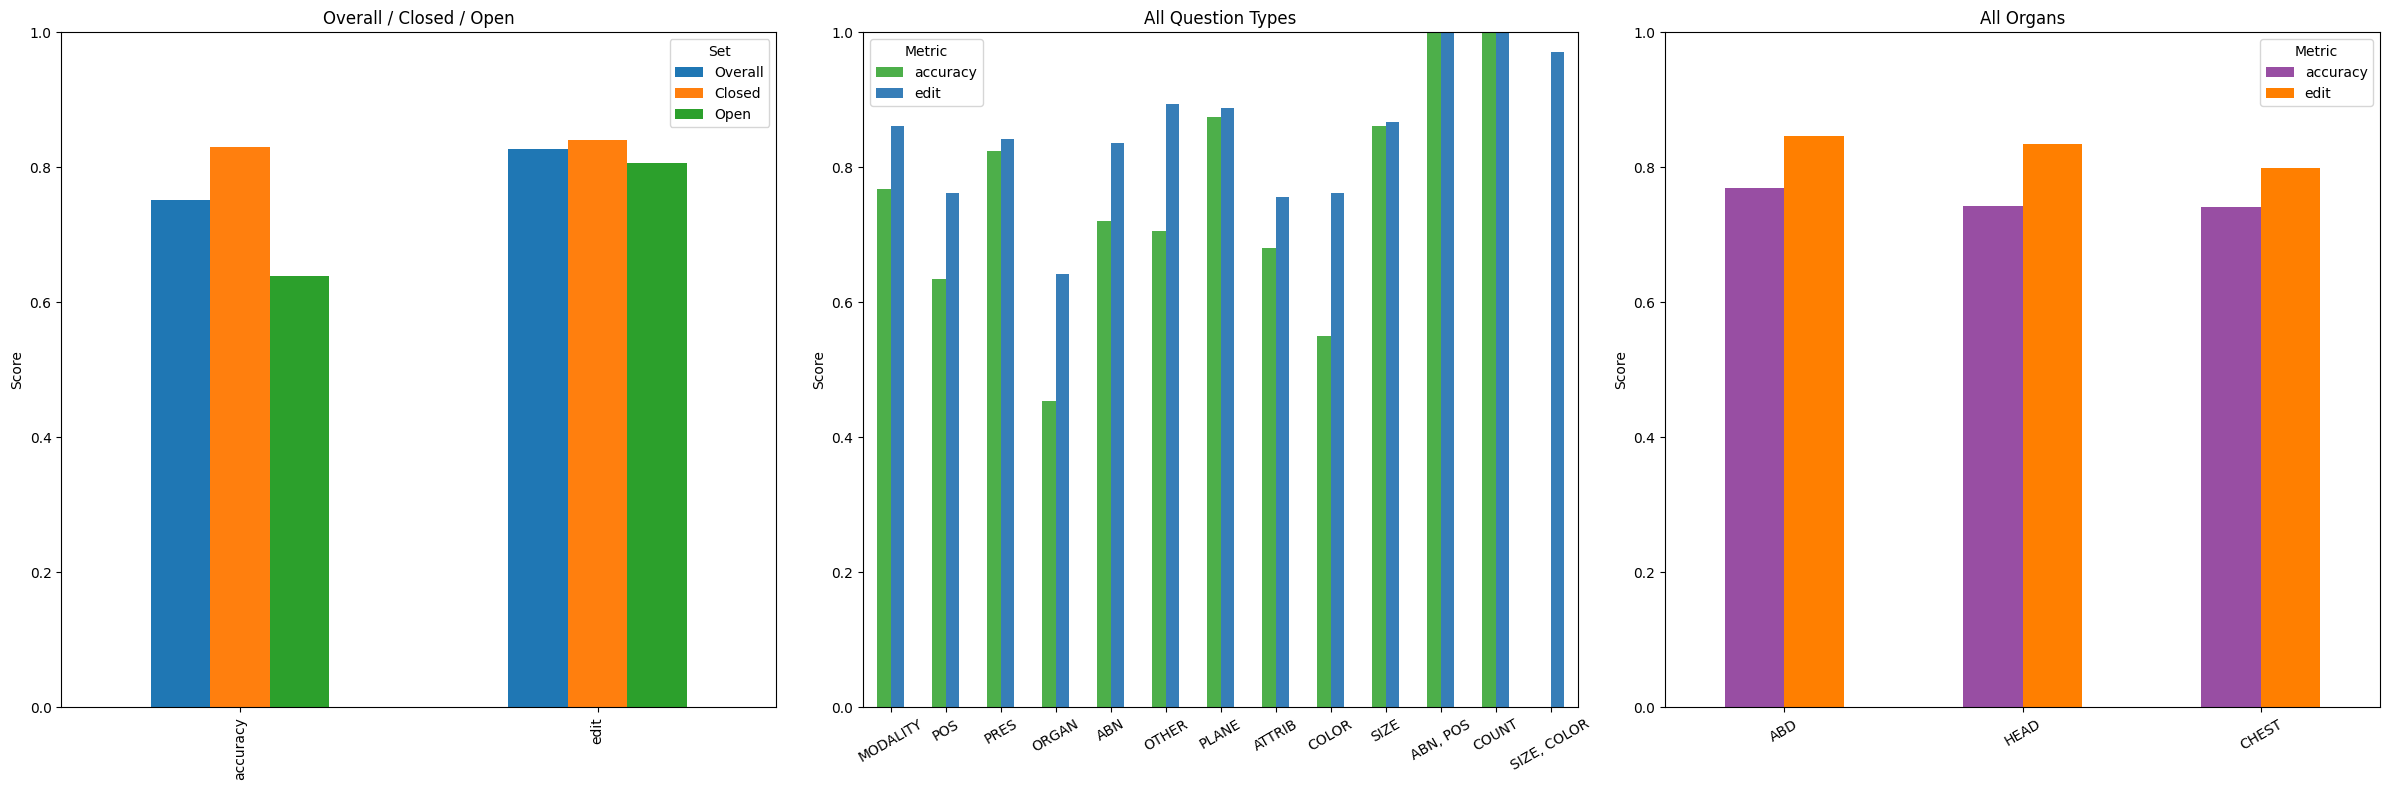

In [51]:
metrics = evaluate_vqa(test_loader, eval_model, device)
plot_vqa_summary(metrics)

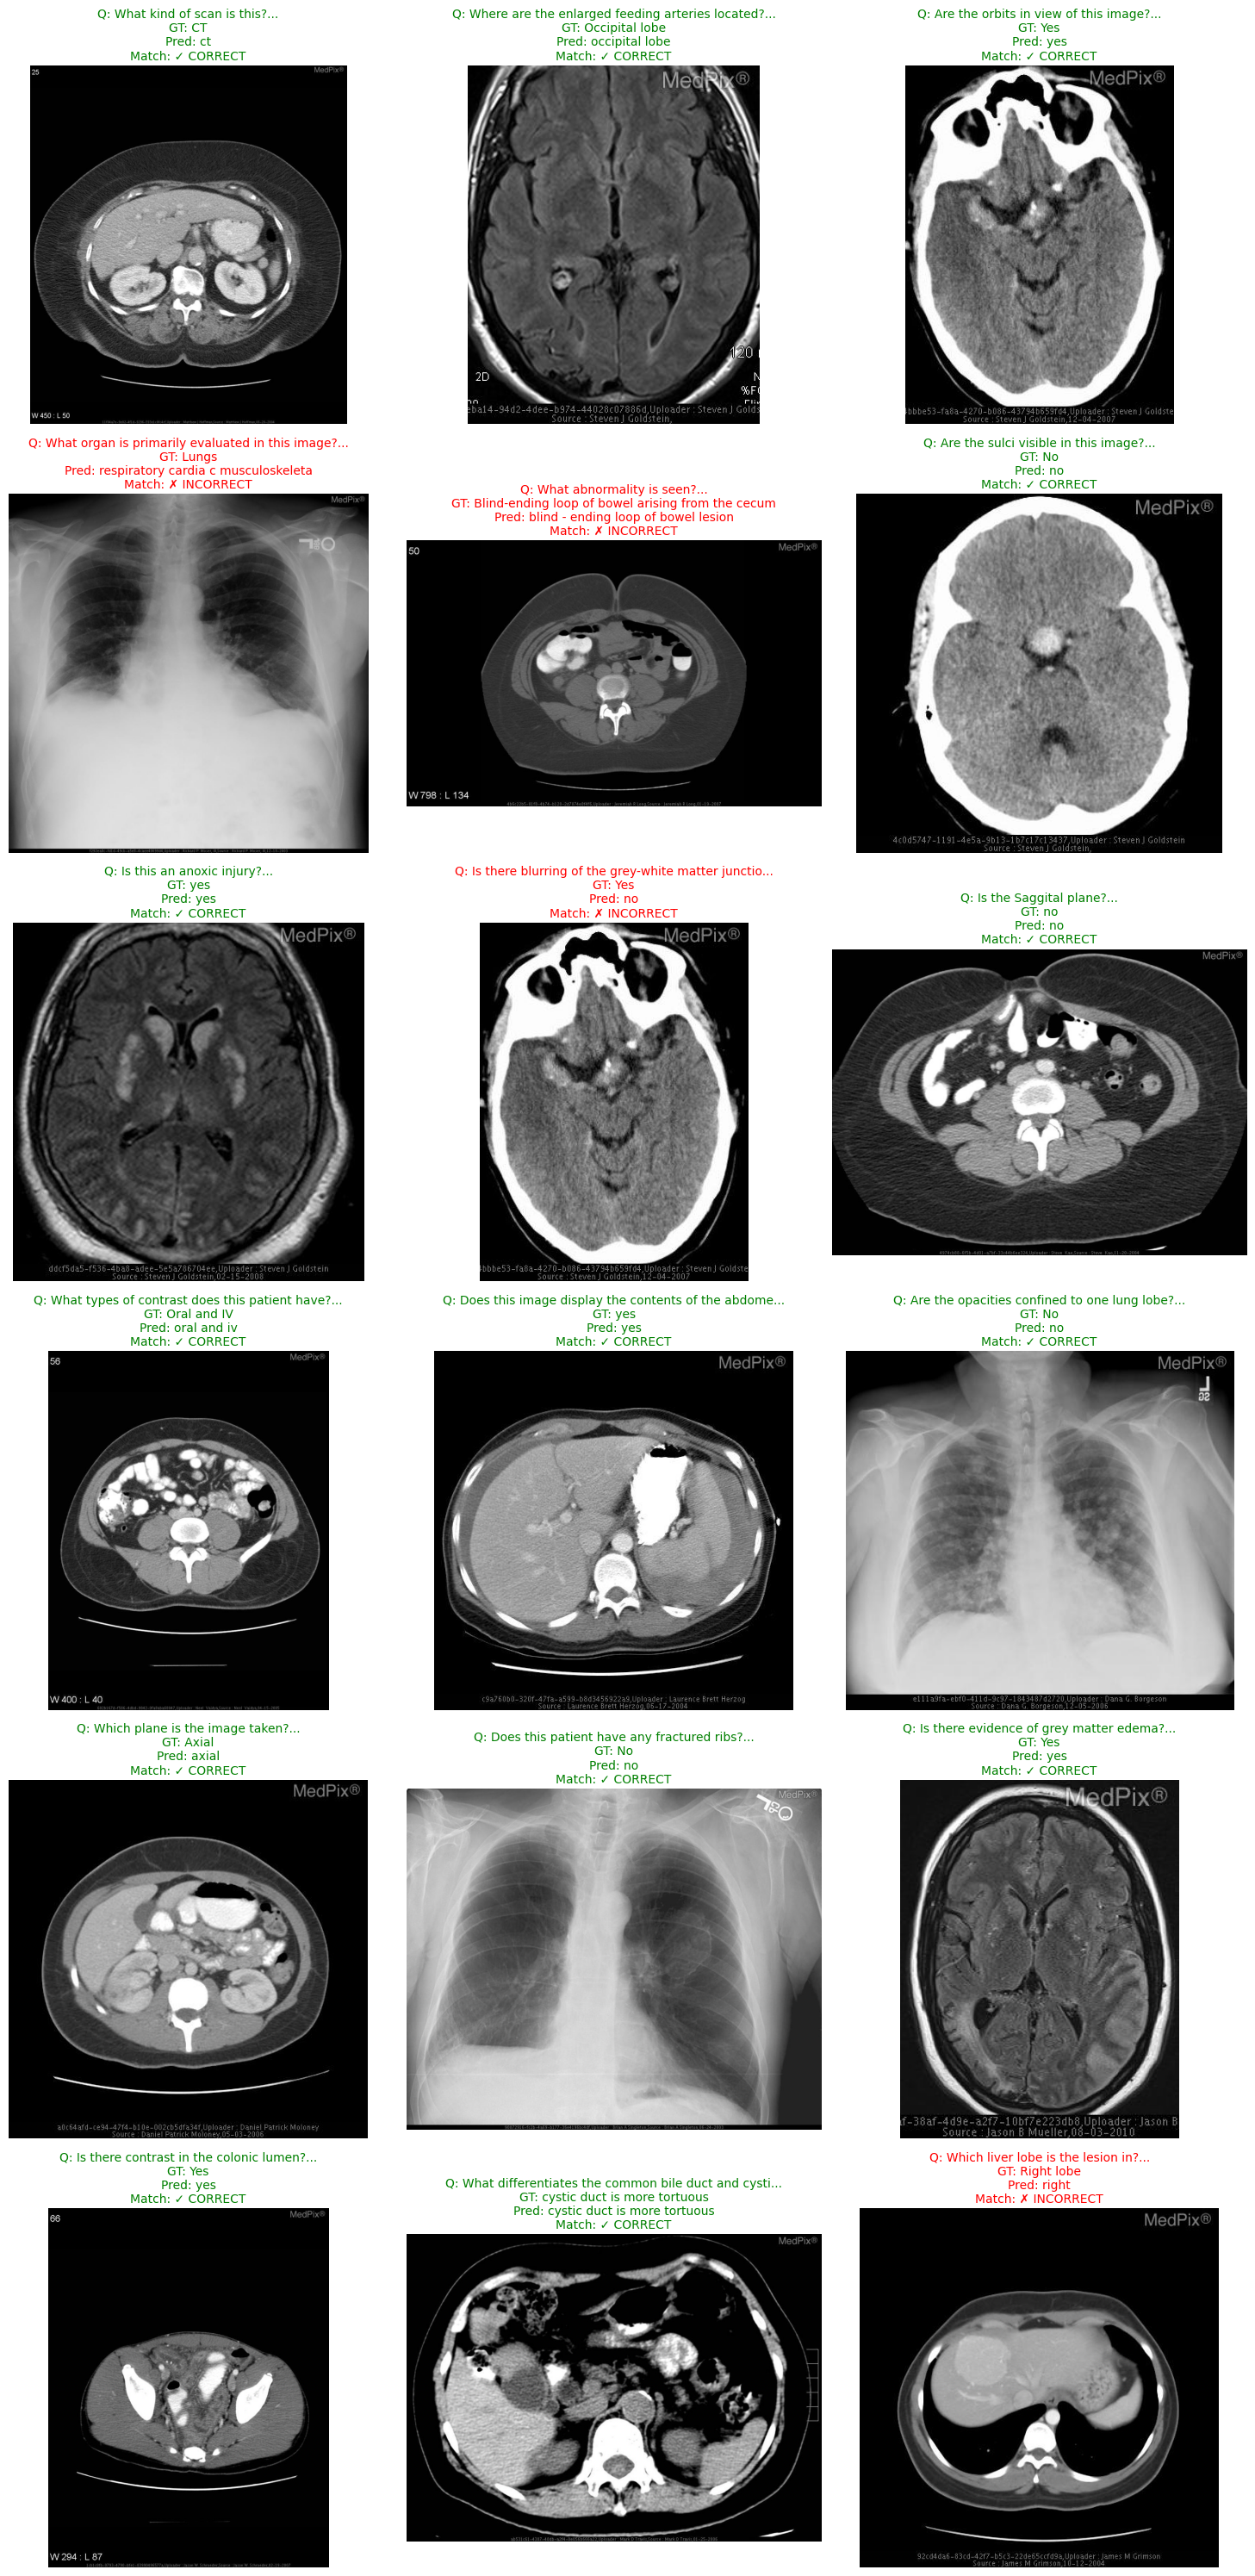

In [52]:
plot_examples(test_loader, eval_model, device, num_examples=18)